# Notebook to explore the fitness data



In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path
from os import path

home = Path(path.abspath('..'))
data = home / 'book_data'



## Read the Data

The data is kept in an excel file called *Fitness.csv*, in a sheet named "Data."

Need to fill the Nan/Blank columns with 0.

In [63]:
values = {"Str_Trng":0, "Func_Trng":0, "Yoga":0, "Run":0, "Walk":0, "Hike":0, "Bike":0,"Other": 0}
raw_df = pd.read_excel(data / 'Fitness.xlsx' ,sheet_name='Data').fillna(value=values)


In [64]:
raw_df

,Date,Weight,BF,Activity,Str_Trng,Func_Trng,Yoga,Run,Walk,Hike,Bike,Other,Steps,Miles,Flights
0,2024-08-16,185.6,NaN,1130.0,472.0,0.0,0.0,0.0,234.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2024-08-17,186.3,NaN,1946.0,495.0,0.0,0.0,0.0,0.0,0.0,261.0,0.0,NaN,NaN,NaN
2,2024-08-18,184.5,NaN,1693.0,0.0,0.0,0.0,0.0,0.0,0.0,1273.0,0.0,NaN,NaN,NaN
3,2024-08-19,185.1,NaN,1081.0,445.0,0.0,0.0,0.0,264.0,0.0,0.0,0.0,NaN,NaN,NaN
4,2024-08-20,184.6,NaN,1113.0,466.0,0.0,0.0,0.0,187.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2024-11-28,178.7,24.6,1211.0,424.0,0.0,0.0,0.0,0.0,193.0,0.0,0.0,16809.0,7.15,15.0
81,2024-11-29,177.6,24.5,1229.0,500.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,18166.0,7.62,19.0
82,2024-11-30,177.6,24.6,1058.0,0.0,0.0,457.0,0.0,189.0,0.0,0.0,0.0,9577.0,3.93,14.0
83,2024-12-01,178.8,24.7,1026.0,425.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,15906.0,6.49,5.0


## Calculations

The data is simply as recorded from the data sources. There are a few calculations to make.

The first is to calculate the active calories from the named activities.These activities record data when in the fitness mode.  This Series contains the "residual" value of activity (kCal) not associated with any activity.


In [65]:
raw_df['Step_Act'] = raw_df.apply(lambda row: (row['Activity']-(row['Str_Trng']+
                                                row['Func_Trng']+
                                                row['Yoga']+
                                                row['Run']+
                                                row['Walk']+
                                                row['Hike']+
                                                row['Bike']+
                                                row['Other'])
                                                ), axis=1)

steps_df=raw_df.loc[:,['Step_Act','Steps','Flights']].dropna()
steps_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 49 to 84
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Step_Act  34 non-null     float64
 1   Steps     34 non-null     float64
 2   Flights   34 non-null     float64
dtypes: float64(3)
memory usage: 1.1 KB


## Investigate Steps

Given that we now have the "excess" actvity associateded with steps, lets see if there is strong corelation using linear regression.

In [66]:
# Helper Function MSE
def MSE(act : np.ndarray, pred : np.ndarray) -> np.float64 :
    n = len(act)
    sum = 0
    for i in range(0,n):
        diff_squared = (act[i] - pred[i])**2
    return diff_squared/n


Score:  0.10825195110436514
Coefficients: [0.01364632]
Intercept: 288.9130781121897
Score: 0.10825195110436514
Coefficients: [0.00952501 4.26028068]
Intercept: 303.8954107562108


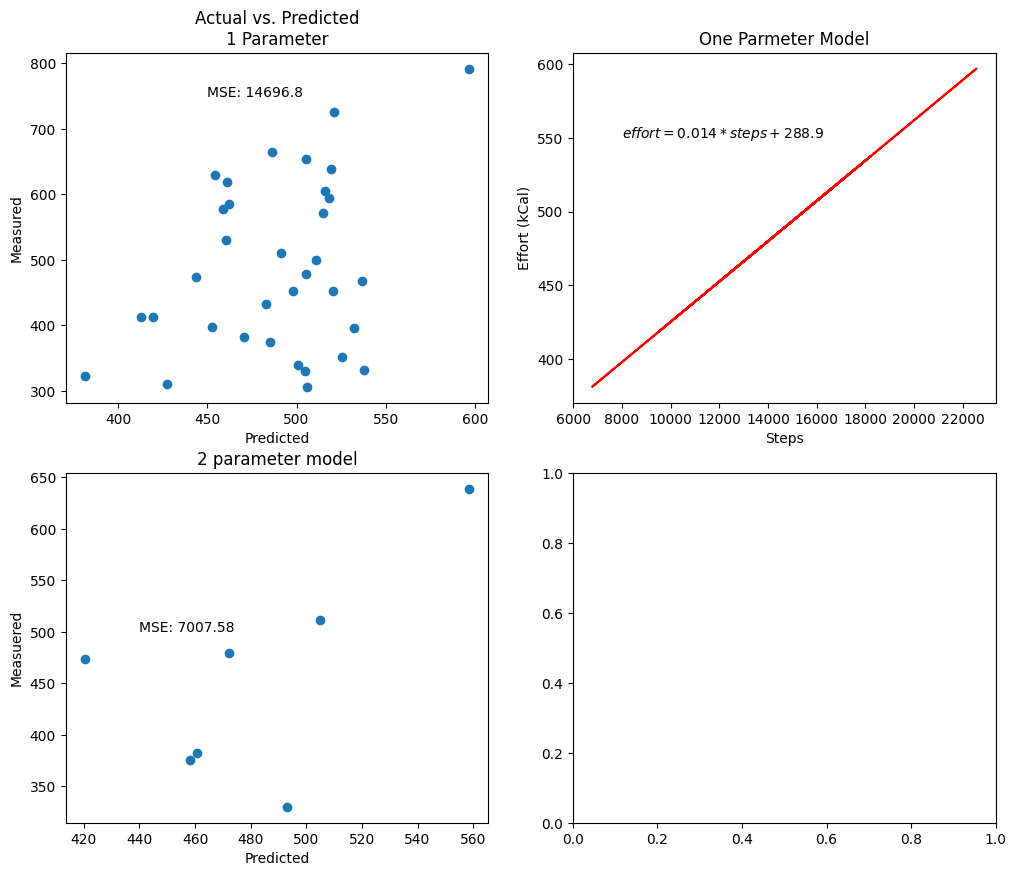

In [67]:
X = steps_df['Steps'].to_numpy().reshape(-1,1)
y1 = steps_df['Step_Act'].to_numpy()


# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y1)

# Make predictions
y1_pred = model.predict(X)


# Create the Plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12.0, 10.0))


# Print the coefficients
print("Score: ", model.score(X,y1))
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print(f"Score: {model.score(X,y1)}")

# Plot the data and the regression line for 1 paramter

ax1.set_title('Actual vs. Predicted\n1 Parameter')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Measured')
ax1.text(450,750, f'MSE: {np.round(mean_squared_error(y1, y1_pred),1)}')
ax1.scatter(y1_pred, y1)


ax2.set_title('One Parmeter Model')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Effort (kCal)')
ax2.text(8000, 550, f'$effort = {np.round(model.coef_[0],3)} * steps + {np.round(model.intercept_,1)}$')
ax2.plot(X, y1_pred, color='red')

# Prepare your data
X2 = steps_df[['Steps', 'Flights']]  # Independent variables
y2 = steps_df['Step_Act']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)# Dependent variable

# Create and fit the model
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Make predictions
y_pred = model2.predict(X_test)

# Evaluate the model (e.g., using mean squared error)

# Access model coefficients and intercept
coefficients = model2.coef_
intercept = model2.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

ax3.set_title('2 parameter model')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Measuered')
ax3.text(440, 500, f'MSE: {np.round(mean_squared_error(y_test, y_pred),2)}')
ax3.scatter(y_pred, y_test)


plt.show()


## Lean Body Mass

$ LBM = Weight * (1 - \frac{BF}{100}) $

In [68]:
LBM_df = raw_df.loc[:,['Date','Weight','BF']].dropna()
LBM_df['LBM'] = LBM_df['Weight']*(1 - (LBM_df['BF']/100))

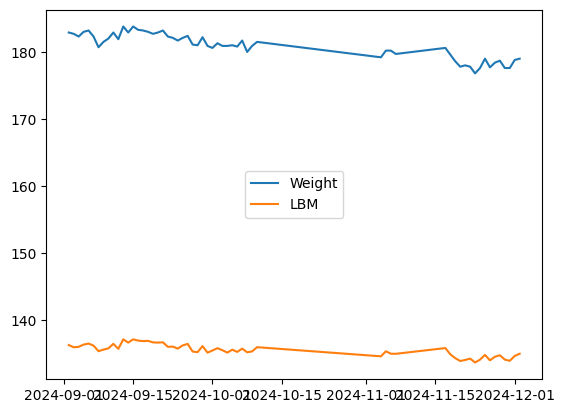

In [69]:
#LBM_df
fig, ax = plt.subplots()
ax.plot(LBM_df['Date'], LBM_df.loc[:,['Weight','LBM']], label=['Weight','LBM'])


plt.legend(loc='center') 
plt.show()